In [ ]:
#export
import tempfile
from fastai2.basics import *
from fastai2.learner import Callback

In [ ]:
from nbdev.showdoc import *

In [ ]:
#default_exp callback.captum

# Captum
Captum is the Model Interpretation Library from PyTorch as available [here](https://captum.ai)

To use this we need to install the package using 

`conda install captum -c pytorch`

or 

`pip install captum`

This is a Call back to use Captum.

In [ ]:
# export

# Dirty hack as json_clean doesn't support CategoryMap type

from ipykernel import jsonutil

_json_clean=jsonutil.json_clean
def json_clean(o):
    o = list(o.items) if isinstance(o,CategoryMap) else o
    return _json_clean(o)

jsonutil.json_clean = json_clean

In [ ]:
#export
from captum.attr import IntegratedGradients,NoiseTunnel,GradientShap,Occlusion
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap


from captum.insights import AttributionVisualizer, Batch
from captum.insights.features import ImageFeature

# Gradient Based Attribution

## Integrated Gradients Callback

The Distill Article [here](https://distill.pub/2020/attribution-baselines/) provides a good overview of what baseline image to choose. We can try them one by one.

In [ ]:
#export
class IntegratedGradientsCallback(Callback):
    "Integrated Gradient Captum Callback for Resnet Interpretation"
    def __init__(self):
        pass

    def visualize(self,inp, baseline_type='zeros',n_steps=1000 ,cmap_name='custom blue',colors=None,N=256,methods=['original_image','heat_map'],signs=["all", "positive"],outlier_perc=1):
        tls = L([TfmdLists(inp, t) for t in L(ifnone(self.dl.tfms,[None]))])
        inp_data=list(zip(*(tls[0],tls[1])))[0]
        return self._visualize(inp_data,n_steps,cmap_name,colors,N,methods,signs,outlier_perc,baseline_type)
    
    def get_baseline_img(self, img_tensor,baseline_type):
        if baseline_type=='zeros': return img_tensor*0
        if baseline_type=='uniform': return torch.rand(img_tensor.shape)
    
    def _visualize(self,inp_data,n_steps=200,cmap_name='custom blue',colors=None,N=256,methods=['original_image','heat_map'],signs=["all", "positive"],outlier_perc=1,baseline_type='zeros'):
        
        self._integrated_gradients = self._integrated_gradients if hasattr(self,'_integrated_gradients') else IntegratedGradients(self.model)
        dl = self.dls
        dec_data=dl.after_item(inp_data)
        dec_pred=inp_data[1]
        dec_img=dec_data[0]
        enc_inp,enc_preds=dl.after_batch(to_device(dl.before_batch(dec_data),dl.device))
        
        baseline=self.get_baseline_img(enc_inp,baseline_type).to(dl.device)
        
        colors = [(0, '#ffffff'),(0.25, '#000000'),(1, '#000000')] if colors is None else colors
        attributions_ig = self._integrated_gradients.attribute(enc_inp,baseline, target=enc_preds, n_steps=200)
        default_cmap = LinearSegmentedColormap.from_list(cmap_name,colors, N=N)
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                              np.transpose(dec_img.numpy(), (1,2,0)),
                                              methods=methods,
                                              cmap=default_cmap,
                                              show_colorbar=True,
                                              signs=signs,
                                              outlier_perc=outlier_perc, titles=[f'Original Image - ({dec_pred})', 'IG'])

In [ ]:
#slow

from fastai2.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(128))

learn = cnn_learner(dls, resnet34, metrics=error_rate,cbs=IntegratedGradientsCallback())
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.383905,0.122443,0.050744,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.142324,0.060729,0.025710,00:13


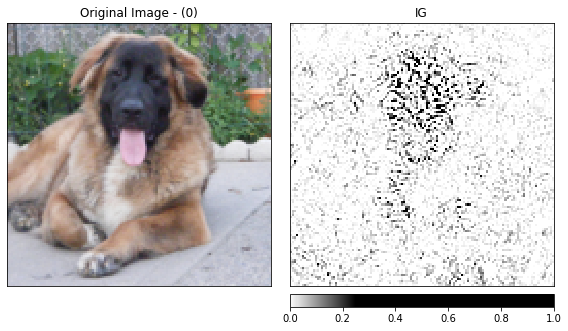

In [ ]:
from random import randint
paths=list(path.iterdir())
idx=randint(0,len(paths))
learn.integrated_gradients.visualize(paths[idx],baseline_type='uniform')

## Noise Tunnel

In [ ]:
#export
class NoiseTunnelCallback(Callback):
    "Captum Callback for Resnet Interpretation"
    def __init__(self):
        pass

    def after_fit(self):
        self.integrated_gradients = IntegratedGradients(self.model)
        self._noise_tunnel= NoiseTunnel(self.integrated_gradients)
        
    def visualize(self,inp_data,cmap_name='custom blue',colors=None,N=256,methods=['original_image','heat_map'],signs=["all", "positive"],nt_type='smoothgrad'):
        dl = self.dls.test_dl(L(inp_data),with_labels=True, bs=1)
        
        self.enc_inp,self.enc_preds= dl.one_batch()
        dec_data=dl.decode((self.enc_inp,self.enc_preds))
        self.dec_img,self.dec_pred=dec_data[0][0],dec_data[1][0]
        
        self.colors = [(0, '#ffffff'),(0.25, '#000000'),(1, '#000000')] if colors is None else colors
        attributions_ig_nt = self._noise_tunnel.attribute(self.enc_inp.to(self.dl.device), n_samples=1, nt_type=nt_type, target=self.enc_preds)
        default_cmap = LinearSegmentedColormap.from_list(cmap_name, 
                                                 self.colors, N=N)
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                              np.transpose(self.dec_img.numpy(), (1,2,0)),
                                              methods,signs,
                                              cmap=default_cmap,
                                              show_colorbar=True,titles=[f'Original Image - ({self.dec_pred})', 'Noise Tunnel'])

In [ ]:
#slow

from fastai2.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(128))

learn = cnn_learner(dls, resnet34, metrics=error_rate,cbs=NoiseTunnelCallback())
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.373885,0.148033,0.052097,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.144305,0.071942,0.021651,00:13


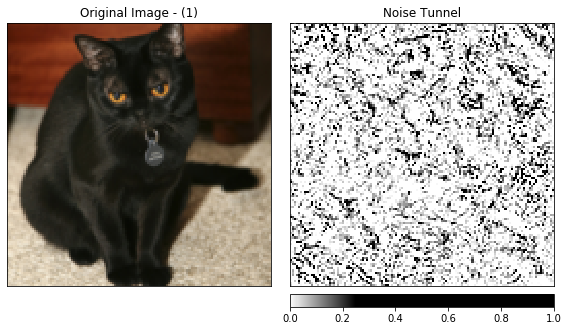

In [ ]:
paths=list(path.iterdir())
from random import randint
idx=randint(0,len(paths))
path_img=paths[idx]

learn.noise_tunnel.visualize(path_img,nt_type='smoothgrad')

# Occlusion

In [ ]:
#export
class OcclusionCallback(Callback):
    "Captum Callback for Resnet Interpretation"
    def __init__(self):
        pass

    def after_fit(self):
        self._occlusion = Occlusion(self.model)
        
    def _formatted_data_iter(self,dl):
        normalize_func= next((func for func in dl.after_batch if type(func)==Normalize),noop)
        dl_iter=iter(dl)
        while True:
            images,labels=next(dl_iter)
            images=normalize_func.decode(images).to(dl.device)
            return images,labels
        
    def visualize(self,inp_data,cmap_name='custom blue',colors=None,N=256,methods=['original_image','heat_map'],signs=["all", "positive"],strides = (3, 4, 4), sliding_window_shapes=(3,15, 15), outlier_perc=2):
        dl = self.dls.test_dl(L(inp_data),with_labels=True, bs=1)
        self.dec_img,self.dec_pred=self._formatted_data_iter(dl)
        
        attributions_occ = self._occlusion.attribute(self.dec_img,
                                       strides = strides,
                                       target=self.dec_pred,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=0)
        
        self.colors = [(0, '#ffffff'),(0.25, '#000000'),(1, '#000000')] if colors is None else colors
        default_cmap = LinearSegmentedColormap.from_list(cmap_name, 
                                                 self.colors, N=N)
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                              np.transpose(self.dec_img.squeeze().cpu().numpy(), (1,2,0)),methods,signs,
                                              cmap=default_cmap,
                                              show_colorbar=True,
                                              outlier_perc=outlier_perc,titles=[f'Original Image - ({self.dec_pred.cpu().item()})', 'Occlusion']
                                             )


In [ ]:
#slow

from fastai2.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(128))

learn = cnn_learner(dls, resnet34, metrics=error_rate,cbs=OcclusionCallback())
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.373188,0.130634,0.050744,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.140966,0.054191,0.023681,00:13


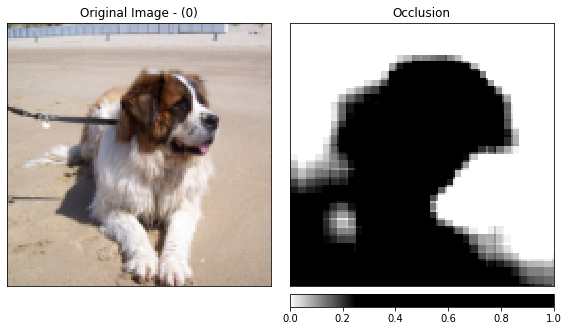

In [ ]:
paths=list(path.iterdir())
from random import randint
idx=randint(0,len(paths))
path_img=paths[idx]

learn.occlusion.visualize(path_img)

## Captum Insights Callback

In [ ]:
#export
class CaptumInsightsCallback(Callback):
    "Captum Insights Callback for Image Interpretation"
    def __init__(self): pass
        
    def _formatted_data_iter(self,dl,normalize_func):
        dl_iter=iter(dl)
        while True:
            images,labels=next(dl_iter)
            images=normalize_func.decode(images).to(dl.device)
            yield Batch(inputs=images, labels=labels)
        
    def visualize(self,inp_data,debug=True):
        _baseline_func= lambda o: o*0
        _get_vocab = lambda vocab: list(map(str,vocab)) if isinstance(vocab[0],bool) else vocab
        dl = self.dls.test_dl(L(inp_data),with_labels=True, bs=4)
        normalize_func= next((func for func in dl.after_batch if type(func)==Normalize),noop)
        
        visualizer = AttributionVisualizer(
            models=[self.model],
            score_func=lambda o: torch.nn.functional.softmax(o, 1),
            classes=_get_vocab(dl.vocab),
            features=[
                ImageFeature(
                    "Image",
                    baseline_transforms=[_baseline_func],
                    input_transforms=[normalize_func],
                )
            ],
            dataset=self._formatted_data_iter(dl,normalize_func)
        )
        visualizer.render(debug=debug)
        

In [ ]:
#slow

from fastai2.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(128))

learn = cnn_learner(dls, resnet34, metrics=error_rate,cbs=CaptumInsightsCallback())
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time


In [ ]:
paths=list(path.iterdir())

learn.captum_insights.visualize(paths)